# <p style="text-align:center;color:#0099cc">Text Classification</p>

In this notebook, we're going to train a model to predict emotion class of a text using the famous emotion dataset of transformers library. We are going to use different fine tuning approaches, such p-tuning, LoRA, and also different base models such as encoders and encoder-decoders.

## <font color="#CB0A77">Loading Libraries and data</font>

In [ ]:
%pip install contractions transformers datasets evaluate peft 

In [3]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# DL
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset

# 🤗
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding, DataCollatorForSeq2Seq
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

In [4]:
dataset = load_dataset("emotion", trust_remote_code=True)

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
class_count = dataset["train"].features["label"].num_classes
class_count

6

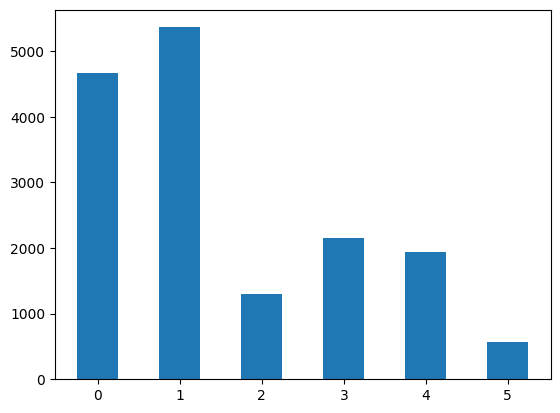

In [6]:
plt.hist(dataset["train"]["label"], bins=np.arange(class_count+1)-0.5, align="mid", rwidth=0.5)
plt.show()

<font color="cyan">
As evident from the chart above, the data exhibits an imbalance. Although the distribution is consistent across validation and test datasets, it is generally recommended to address such disparities. One approach is to employ uniform sampling when dealing with large datasets. However, when data is scarce, oversampling techniques like SMOTE are more suitable. For textual data, data augmentation methods can be leveraged, with synonym replacement being a promising strategy.

### Defining some project level variables

In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# putting models in a tuple for easy access if changing the model is desired
downloaded_models = ("distilbert/distilbert-base-uncased" , 
                     "FacebookAI/roberta-base", 
                     "google-bert/bert-base-uncased", 
                     "albert/albert-base-v2",
                     "microsoft/MiniLM-L12-H384-uncased",
                     "FacebookAI/roberta-large",    #5
                     "google-t5/t5-base",
                     "google-t5/t5-small",
                     "google/flan-t5-small",
                     "google/flan-t5-base")

In [8]:
def show_train_param_count(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total trainable parameters: {trainable_params:,}')

## <font color="#CB0A77">Fine tuning a complete model</font>

### <font color="orangered">Constants</font>

In [65]:
BASE_MODEL_NAME = downloaded_models[1]
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 3

### <font color="orangered">Tokenizing</font>

In [66]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
def preprocess_function(examples):
    # We don't specify padding here, as we're gonna pad the 
    # texts dynamically in each batch using collator
    return tokenizer(examples["text"], truncation=True)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [67]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

In [68]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt", padding="longest")

### <font color="orangered">Model</font>

In [69]:
base_model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_NAME, num_labels=class_count)
show_train_param_count(base_model)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total trainable parameters: 124,650,246


In [70]:
accuracy_fn = evaluate.load("accuracy")
f1_metric_fn = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy =  accuracy_fn.compute(predictions=predictions, references=labels)
    f1_micro = f1_metric_fn.compute(predictions=predictions, references=labels, average='macro')
    return {**accuracy, **f1_micro}

In [72]:

training_args = TrainingArguments(output_dir='./FT', 
                                  save_strategy="epoch",
                                  logging_steps=0.2,
                                  eval_strategy="steps",
                                  eval_steps = 0.2,
                                  learning_rate=LEARNING_RATE,
                                  num_train_epochs=EPOCHS,
                                  per_device_train_batch_size=BATCH_SIZE,
                                  per_device_eval_batch_size=BATCH_SIZE,
                                  push_to_hub=False,
                                  report_to="none"
                                  )
ft_trainer = Trainer(model=base_model, 
                  args=training_args, 
                  train_dataset=train_dataset, 
                  eval_dataset=eval_dataset,
                  tokenizer=tokenizer,
                  data_collator = data_collator,
                  compute_metrics=compute_metrics
                  )

In [76]:
torch.cuda.empty_cache()

In [73]:
ft_trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
75,0.749600,0.347826,0.887500,0.857036
150,0.254700,0.190538,0.929500,0.899681
225,0.162600,0.140467,0.938500,0.914660
300,0.123300,0.126066,0.939000,0.914755
375,0.099800,0.113412,0.940000,0.913046


TrainOutput(global_step=375, training_loss=0.27800255330403645, metrics={'train_runtime': 281.6917, 'train_samples_per_second': 170.399, 'train_steps_per_second': 1.331, 'total_flos': 1476961173748224.0, 'train_loss': 0.27800255330403645, 'epoch': 3.0})

### <font color="orangered">Prediction</font>

In [74]:
prediction_output = ft_trainer.predict(test_dataset)

In [75]:
prediction_logits = prediction_output.predictions
predictions_labels = np.argmax(prediction_logits, axis=-1)
print(classification_report(test_dataset["label"], predictions_labels, digits=3))

              precision    recall  f1-score   support

           0      0.967     0.969     0.968       581
           1      0.937     0.977     0.956       695
           2      0.909     0.755     0.825       159
           3      0.937     0.913     0.924       275
           4      0.847     0.942     0.892       224
           5      0.955     0.636     0.764        66

    accuracy                          0.933      2000
   macro avg      0.925     0.865     0.888      2000
weighted avg      0.934     0.933     0.931      2000



## <font color="#CB0A77">Fine tuning with LoRA on encoder model</font>

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

### <font color="orangered">Constants</font>

In [77]:
BASE_MODEL_NAME = downloaded_models[1]
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 3
RANK = 8
ALPHA = 32

### <font color="orangered">Tokenizing</font>

In [78]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)

def preprocess_function(examples):
    # We don't specify padding here, as we're gonna pad the 
    # texts dynamically in each batch using collator
    return tokenizer(examples["text"], truncation=True)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

In [79]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

In [80]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt", padding="longest")

### <font color="orangered">Model</font>

In [81]:
base_model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_NAME, num_labels=class_count)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
lora_config = LoraConfig(task_type=TaskType.SEQ_CLS, 
                         r=RANK,
                         lora_alpha=ALPHA,
                         lora_dropout=0.2,
                         # target_modules=['query', "key"],
                         )
peft_model = get_peft_model(base_model, lora_config)
peft_model.print_trainable_parameters()

trainable params: 890,118 || all params: 125,540,364 || trainable%: 0.7090


In [83]:
accuracy_fn = evaluate.load("accuracy")
f1_metric_fn = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy =  accuracy_fn.compute(predictions=predictions, references=labels)
    f1_micro = f1_metric_fn.compute(predictions=predictions, references=labels, average='macro')
    return {**accuracy, **f1_micro}

In [84]:
training_args = TrainingArguments(output_dir='./lora',
                                  save_strategy="epoch",
                                  logging_steps=0.2,
                                  eval_strategy="steps",
                                  eval_steps=0.2,
                                  learning_rate=LEARNING_RATE,
                                  num_train_epochs=EPOCHS,
                                  per_device_train_batch_size=BATCH_SIZE,
                                  per_device_eval_batch_size=BATCH_SIZE,
                                  push_to_hub=False,
                                  report_to="none"
                                  )

lora_trainer = Trainer(model=peft_model, 
                  args=training_args, 
                  train_dataset=train_dataset, 
                  eval_dataset=eval_dataset,
                  tokenizer=tokenizer,
                  data_collator = data_collator,
                  compute_metrics=compute_metrics
                  )

In [89]:
torch.cuda.empty_cache()

In [86]:
lora_trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
75,1.498200,1.065976,0.613500,0.386715
150,0.883900,0.693922,0.741500,0.592678
225,0.662700,0.555475,0.798500,0.719732
300,0.589400,0.516418,0.807000,0.736212
375,0.565300,0.493163,0.823500,0.762856


TrainOutput(global_step=375, training_loss=0.8399048461914063, metrics={'train_runtime': 200.8232, 'train_samples_per_second': 239.016, 'train_steps_per_second': 1.867, 'total_flos': 1492310283088896.0, 'train_loss': 0.8399048461914063, 'epoch': 3.0})

### <font color="orangered">Prediction</font>

In [87]:
prediction_output = lora_trainer.predict(test_dataset)

In [88]:
prediction_logits = prediction_output.predictions
predictions_labels = np.argmax(prediction_logits, axis=-1)
print(classification_report(test_dataset["label"], predictions_labels, digits=3))

              precision    recall  f1-score   support

           0      0.851     0.852     0.851       581
           1      0.878     0.905     0.892       695
           2      0.676     0.579     0.624       159
           3      0.798     0.745     0.771       275
           4      0.715     0.875     0.787       224
           5      0.857     0.455     0.594        66

    accuracy                          0.824      2000
   macro avg      0.796     0.735     0.753      2000
weighted avg      0.824     0.824     0.820      2000



## <font color="#CB0A77">Fine tuning with Lora and an encoder-decoder model</font>

In [9]:
from peft import LoraConfig, get_peft_model, TaskType
from transformers import AutoModelForSeq2SeqLM

### <font color="orangered">Constants</font>

In [33]:
BASE_MODEL_NAME = downloaded_models[9]
BATCH_SIZE = 32
# LEARNING_RATE = 2e-5
EPOCHS = 3
RANK = 2
ALPHA = 4

### <font color="orangered">Tokenizing</font>

In [11]:
label_names = dataset['train'].features['label'].names
id2label_dict = {i: label for i, label in enumerate(label_names)}
label2id_dict = {label: i for i, label in enumerate(label_names)}

def id2label(ids):
    return [id2label_dict[id] for id in ids]

def label2id(labels):
    return [
        label2id_dict.get(label, 6)
        for label in labels
    ]

In [12]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [13]:
class_names = dataset["train"].features["label"].names

In [14]:
def t5_preprocess_function(examples):
    task_prefix = f"choose sentiment from this list {class_names}: "
    inputs = [task_prefix + text for text in examples['text']]
    labels = dataset["train"].features["label"].int2str(examples['label'])
    model_inputs = tokenizer(inputs, truncation=True, max_length=1024)
    encoded_labels = tokenizer(text_target=labels)
    model_inputs['label'] = encoded_labels['input_ids']
    return model_inputs

In [15]:
tokenized_datasets = dataset.map(t5_preprocess_function, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [16]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

In [17]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, padding="longest", return_tensors="pt")

### <font color="orangered">Model</font>

In [32]:
base_model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL_NAME)
lora_config = LoraConfig(task_type=TaskType.SEQ_2_SEQ_LM, 
                         r=RANK,
                         lora_alpha=ALPHA,
                         # lora_dropout=0.1,
                         )
peft_model = get_peft_model(base_model, lora_config)
peft_model.print_trainable_parameters()

trainable params: 221,184 || all params: 247,799,040 || trainable%: 0.0893


In [19]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load('f1')

In [29]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(
        logits, tuple
    ):  # if the model also returns hidden_states or attentions
        logits = logits[0]
    predictions = np.argmax(logits, axis=-1)
    text_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
#     print("decoded predictions:", text_predictions)
    int_predictions = label2id([label.strip() for label in text_predictions])

    text_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
#     print("decoded labels:", text_labels)
    int_labels = label2id([label.strip() for label in text_labels])
    
    f1 = f1_metric.compute(predictions=int_predictions, references=int_labels, average='macro')
    accuracy = accuracy_metric.compute(predictions=int_predictions, references=int_labels)
    return {**accuracy, **f1}

In [38]:
training_args = TrainingArguments(output_dir='./flan-t5', 
                                  save_strategy="epoch",
                                  save_safetensors=False,
                                  logging_strategy="steps",
                                  logging_steps = 0.2,
                                  eval_strategy="steps",
                                  eval_steps = 0.2,
                                #   learning_rate=LEARNING_RATE,
                                #   weight_decay=0.01,
                                  num_train_epochs=EPOCHS,
                                  per_device_train_batch_size=BATCH_SIZE,
                                  per_device_eval_batch_size=BATCH_SIZE,
                                  push_to_hub=False,
                                  report_to="none"
                                  )
t5_trainer = Trainer(model=peft_model, 
                  args=training_args, 
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  tokenizer=tokenizer,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics
                  )

In [37]:
torch.cuda.empty_cache()

In [39]:
t5_trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
300,0.679100,0.428538,0.689000,0.651427
600,0.597400,0.399191,0.711500,0.669319
900,0.546100,0.377466,0.727500,0.682572
1200,0.515000,0.364220,0.740500,0.694939
1500,0.514100,0.360473,0.741500,0.695572


TrainOutput(global_step=1500, training_loss=0.570331298828125, metrics={'train_runtime': 592.3073, 'train_samples_per_second': 81.039, 'train_steps_per_second': 2.532, 'total_flos': 6716895372804096.0, 'train_loss': 0.570331298828125, 'epoch': 3.0})

### <font color="orangered">Prediction</font>

In [40]:
prediction_output = t5_trainer.predict(test_dataset).predictions[0]

In [ ]:
prediction_logits = np.argmax(prediction_output, axis=-1)
text_predictions = tokenizer.batch_decode(prediction_logits, skip_special_tokens=True)
int_predictions = label2id([label.strip() for label in text_predictions])
print(classification_report(dataset["test"]["label"], int_predictions, digits=3, zero_division=0, labels=range(6)))

In [40]:
# This is the reult of T5-base model

              precision    recall  f1-score   support

           0      0.658     0.704     0.680       581
           1      0.642     0.888     0.745       695
           2      0.500     0.038     0.070       159
           3      0.637     0.465     0.538       275
           4      0.711     0.571     0.634       224
           5      0.696     0.242     0.360        66

   micro avg      0.652     0.652     0.652      2000
   macro avg      0.641     0.485     0.504      2000
weighted avg      0.644     0.652     0.619      2000



In [41]:
# This is the reult of flan-T5-base model

              precision    recall  f1-score   support

           0      0.745     0.809     0.776       581
           1      0.797     0.847     0.821       695
           2      0.635     0.384     0.478       159
           3      0.731     0.673     0.701       275
           4      0.695     0.661     0.677       224
           5      0.618     0.636     0.627        66

    accuracy                          0.748      2000
   macro avg      0.703     0.668     0.680      2000
weighted avg      0.743     0.748     0.742      2000

